In [229]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import TextVectorization, Embedding, MaxPooling2D, LSTM, SpatialDropout1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset

# Data Loading

In [341]:
df_dev = pd.read_csv("dataset\subtaskA_clean_dev_cased.csv")
df_dev.head()

,comment_text,conspiratorial
0,Se non ci fossero soldati non ci sarebbero gue...,0
1,"]( ""Shedding of Infectious SARS-CoV-2 Des...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [342]:
list(df_dev['comment_text'])

['Se non ci fossero soldati non ci sarebbero guerre.',
 '](      "Shedding of Infectious SARS-CoV-2 Despite Vaccination"  "Diffusione del SARS-CoV-2 nonostante la vaccinazione"     "La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale.  le indagini sull\'epidemia suggeriscono che le persone vaccinate possono diffondere  Delta"   " questi risultati indicano che anche le persone asintomatiche e comple vaccinate possono diffondere il virus infettivo."   " questi dati indicano che gli individui vaccinati e non vaccinati infettati dalla variante Delta possono trasmettere l\'infezione."',
 'PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA\' La scorsa settimana Elon Musk ha dichiarato di volere che la "libertà di parola" sui social media sia tutelata ai sensi della Legge del Paese. I DEM sono spaventatissimi dalla scelta coraggiosa del magnate dello Spazio di acquistare Twitter  così scon

In [343]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment_text    1840 non-null   object
 1   conspiratorial  1840 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.9+ KB


In [344]:
df_dev.conspiratorial.value_counts()

1    925
0    915
Name: conspiratorial, dtype: int64

Il task è bilanciato.

In [345]:
df_dev.iloc[(1, 0)]

'](      "Shedding of Infectious SARS-CoV-2 Despite Vaccination"  "Diffusione del SARS-CoV-2 nonostante la vaccinazione"     "La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale.  le indagini sull\'epidemia suggeriscono che le persone vaccinate possono diffondere  Delta"   " questi risultati indicano che anche le persone asintomatiche e comple vaccinate possono diffondere il virus infettivo."   " questi dati indicano che gli individui vaccinati e non vaccinati infettati dalla variante Delta possono trasmettere l\'infezione."'

# Additional Text Preprocessing

In [346]:
import re

In [347]:
import nltk

In [348]:
from nltk.corpus import stopwords

In [349]:
print(stopwords.words('italian'))

['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha', 'ab

In [350]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('italian'))

In [351]:
def clean_text(text):
    """ text: a string
        return: modified initial string """
    text = text.lower() # lowercase text
    text = re.sub(r'[/(){}\[\]\|@,;]', ' ', text) # substitute the matched string with space.
    text = re.sub(r'[#+_]', '', text) # substitute bad symbols with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
#df_dev['comment_text'] = df_dev['comment_text'].apply(clean_text)
#df_dev['comment_text'] = df_dev['comment_text'].str.replace('\d+', '')


In [353]:
#%pip install wordcloud

In [354]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [355]:
conspiratorial_msg_text = ''
for conspiratorial_post in list(df_dev[df_dev['conspiratorial'] == 1].comment_text):
    conspiratorial_msg_text += conspiratorial_post

In [356]:
conspiratorial_msg_text

'](      "Shedding of Infectious SARS-CoV-2 Despite Vaccination"  "Diffusione del SARS-CoV-2 nonostante la vaccinazione"     "La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale.  le indagini sull\'epidemia suggeriscono che le persone vaccinate possono diffondere  Delta"   " questi risultati indicano che anche le persone asintomatiche e comple vaccinate possono diffondere il virus infettivo."   " questi dati indicano che gli individui vaccinati e non vaccinati infettati dalla variante Delta possono trasmettere l\'infezione."PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA\' La scorsa settimana Elon Musk ha dichiarato di volere che la "libertà di parola" sui social media sia tutelata ai sensi della Legge del Paese. I DEM sono spaventatissimi dalla scelta coraggiosa del magnate dello Spazio di acquistare Twitter  così scontrandosi frontalmente, e senza paura, con BlackRock, Vanguard

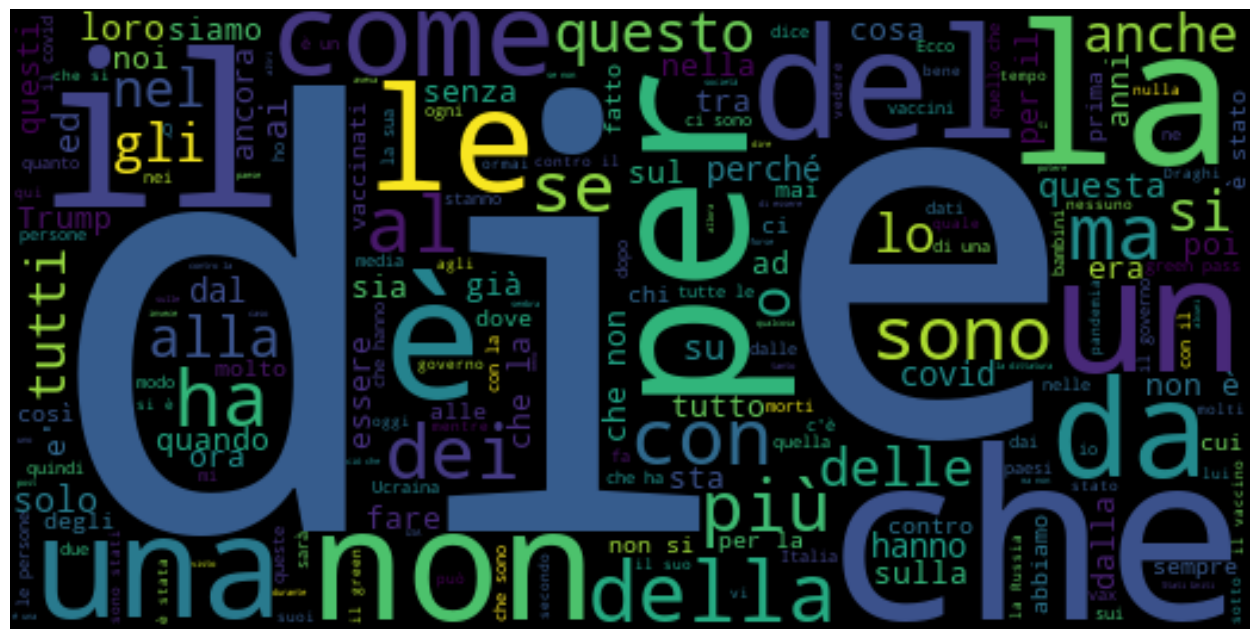

In [357]:
conspiratorial_msg_cloud = WordCloud(width=520,
                                     height=260,
                                     stopwords=STOPWORDS,
                                     #max_font_size=50,
                                     #background_color = "black", colormap = 'Pastel1'
                                     ).generate(conspiratorial_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(conspiratorial_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [358]:
not_conspiratorial_msg_text = ''
for not_conspiratorial_post in list(df_dev[df_dev['conspiratorial'] == 0].comment_text):
    not_conspiratorial_msg_text += not_conspiratorial_post

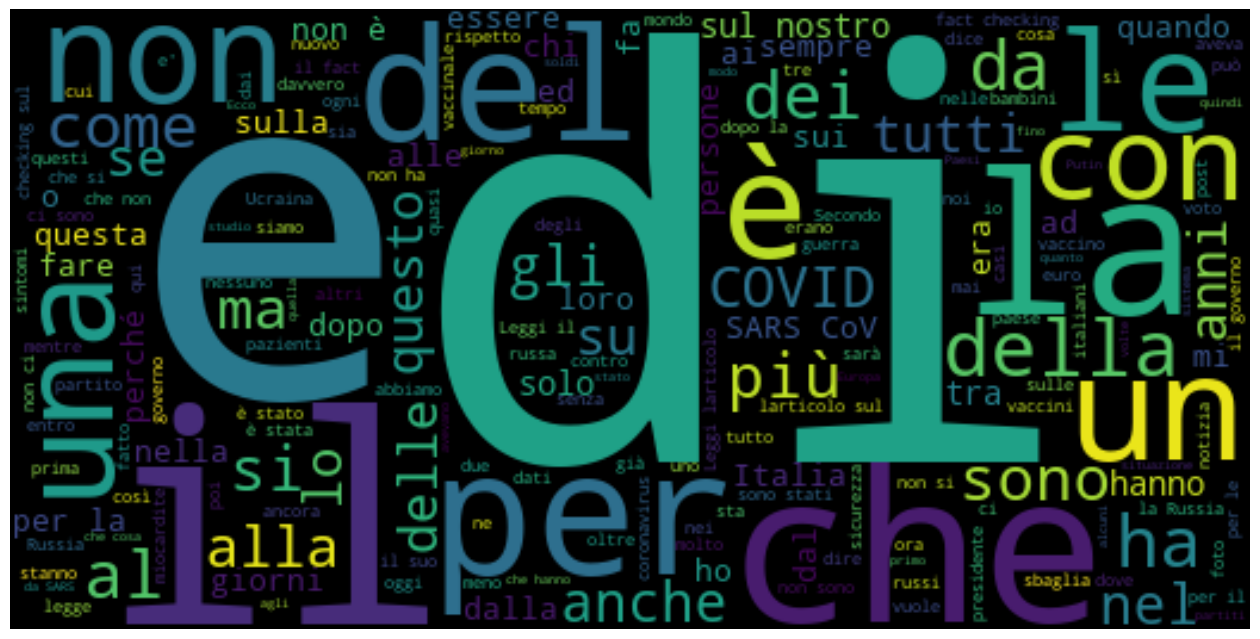

In [359]:
not_conspiratorial_msg_cloud = WordCloud(width=520,
                                     height=260,
                                     stopwords=STOPWORDS,
                                     #max_font_size=50,
                                     #background_color = "black", colormap = 'Pastel1'
                                     ).generate(not_conspiratorial_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(not_conspiratorial_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [360]:
max_length = 0
for post in list(df_dev.comment_text):
    post_length = len(post.split())
    # print(post_length)
    if post_length > max_length:
        max_length = post_length

In [361]:
max_length

645

In [362]:
X_dev = df_dev.comment_text.values

In [363]:
y_dev = df_dev.conspiratorial.values

In [364]:
len(X_dev), len(y_dev)

(1840, 1840)

# Data Splitting

In [365]:
# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(X_dev))
num_validation_samples

368

In [366]:
X_train = X_dev[:-num_validation_samples]
len(X_train)

1472

In [367]:
X_val = X_dev[-num_validation_samples:]
len(X_val)

368

In [368]:
y_train = y_dev[:-num_validation_samples]
len(y_train)

1472

In [369]:
y_val = y_dev[-num_validation_samples:]
len(y_val)

368

# Text Vectorization

In [370]:
vectorize_layer = TextVectorization(max_tokens=20000, # Max vocabulary size (to specifiy when adapting a vocabulary)
                                    output_sequence_length=max_length) # output dim padded or truncated => tensor of shape (batch_size, output_sequence_length)
text_ds = Dataset.from_tensor_slices(X_train)
text_ds

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [371]:
(list(text_ds.as_numpy_iterator()))[0]

b'Se non ci fossero soldati non ci sarebbero guerre.'

text_ds contiene tutti i post, ogni post è di tipo bytes.

In [372]:
vectorize_layer.adapt(text_ds.batch(64))

In [373]:
vectorize_layer.get_vocabulary()[:15]

['',
 '[UNK]',
 'di',
 'e',
 'che',
 'il',
 'la',
 'in',
 'non',
 'per',
 'a',
 'i',
 'è',
 'un',
 'del']

In [374]:
vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
len(vocabulary)

13458

## Word Embeddings

In [375]:
embedding_dim = 128

In [123]:
embeddings_path = '..\..\itwac128.txt'

In [79]:
def load_word_embeddings(emb_path):
    '''crea un dizionario contenente gli embedding di parole presente nel file src_path'''
    embeddings = dict() # dizionario che conterrà gli embedding
    for line in open(emb_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [80]:
embeddings = load_word_embeddings(embeddings_path)

In [81]:
len(embeddings)

1247492

In [92]:
len(embeddings[','])

128

### Creazione di una matrice di embeddings

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the embedding for the word of index i in our vectorizer's vocabulary.

In [298]:
len(vocabulary)

12801

In [376]:
def embedding_init(shape, dtype):
    num_tokens = shape[0]
    embedding_dim = shape[1]
    #num_tokens = len(vocabulary) + 2
    #embedding_dim = 128
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    # print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

# Model Building

In [377]:
from tensorflow.keras import Input

In [397]:
x_train = vectorize_layer(np.array([[s] for s in X_train])).numpy()
x_val = vectorize_layer(np.array([[s] for s in X_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

In [398]:
model = Sequential()
# Start by creating an explicit input layer. It needs to have a shape of (1,) (because we need to guarantee that
# there is exactly one string input per batch), and the dtype needs to be 'string'.
#model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
# The first layer in our model is the vectorization layer. After this layer, we have a tensor of shape
# (batch_size, max_len) containing vocab indices.
#model.add(vectorize_layer)

Now, the model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.

Embedding Layer Arguments

* input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
* output_dim: Integer. Dimension of the dense embedding.
* embeddings_initializer: Initializer for the embeddings matrix (see keras.initializers).
* embeddings_regularizer: Regularizer function applied to the embeddings matrix (see keras.regularizers).
* embeddings_constraint: Constraint function applied to the embeddings matrix (see keras.constraints).
* mask_zero: Boolean, whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).
* input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
* sparse: If True, calling this layer returns a tf.SparseTensor. If False, the layer returns a dense tf.Tensor. For an entry with no features in a sparse tensor (entry with value 0), the embedding vector of index 0 is returned by default.

In [399]:
# >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
# The model will take as input an integer matrix of size (batch, input_length), and the largest integer (i.e.
# word index) in the input should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch dimension.
model.add(Embedding(
    input_dim = len(vocabulary),
    output_dim = embedding_dim,
    embeddings_initializer=embedding_init,
    input_length=max_length)) 
    #mask_zero=True)) # 0-padding should be masked out

In [400]:
model.add(SpatialDropout1D(0.2))

LSTM arguments:
* units: Positive integer, dimensionality of the output space.
* activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* recurrent_activation: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).

In [401]:
RNN_HIDDEN_SIZE = 100

In [402]:
model.add(LSTM(RNN_HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))

In [403]:
model.add(Dropout(0.2))

In [404]:
model.add(Dense(50))

In [405]:
model.add(Dense(2, activation='softmax'))

In [406]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 645, 128)          1722624   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 645, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_14 (LSTM)              (None, 100)               91600     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 50)                5050      
                                                                 
 dense_28 (Dense)            (None, 2)                 102       
                                                     

In [407]:
# plot_model(model, show_shapes=True)

In [408]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [409]:
x_train.shape

(1472, 645)

In [410]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
46/46 [==============================] - 33s 667ms/step - loss: 0.6944 - accuracy: 0.4946 - val_loss: 0.6927 - val_accuracy: 0.5190
Epoch 2/10
46/46 [==============================] - 36s 778ms/step - loss: 0.6941 - accuracy: 0.4925 - val_loss: 0.6936 - val_accuracy: 0.4810
Epoch 3/10
46/46 [==============================] - 35s 764ms/step - loss: 0.6938 - accuracy: 0.5020 - val_loss: 0.6926 - val_accuracy: 0.5190
Epoch 4/10
46/46 [==============================] - 35s 752ms/step - loss: 0.6943 - accuracy: 0.4925 - val_loss: 0.6938 - val_accuracy: 0.4810
Epoch 5/10
46/46 [==============================] - 34s 749ms/step - loss: 0.6936 - accuracy: 0.5095 - val_loss: 0.6928 - val_accuracy: 0.5190
Epoch 6/10
46/46 [==============================] - 34s 742ms/step - loss: 0.6939 - accuracy: 0.4973 - val_loss: 0.6935 - val_accuracy: 0.4810
Epoch 7/10
46/46 [==============================] - 35s 754ms/step - loss: 0.6943 - accuracy: 0.4891 - val_loss: 0.6935 - val_accuracy: 0.4810

In [411]:
history = model.history

In [393]:
import matplotlib.pyplot as plt

In [394]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

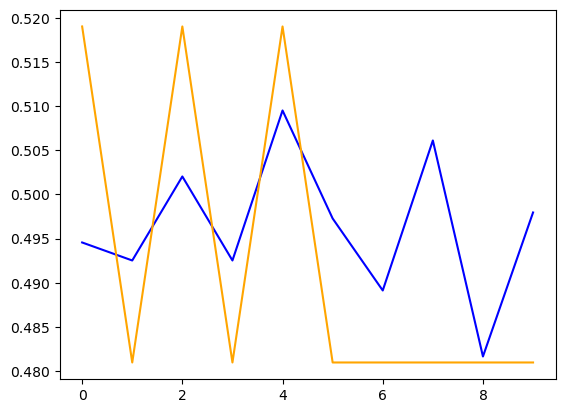

In [412]:
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='orange')
plt.show()

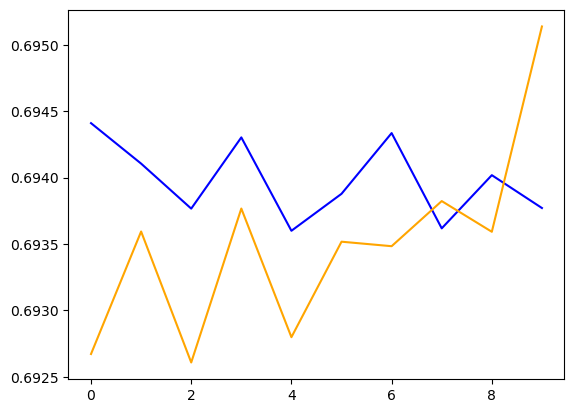

In [413]:
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orange')
plt.show()

https://keras.io/examples/nlp/pretrained_word_embeddings/